In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.utils
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [18]:
plt.rcParams['figure.dpi'] = 200
print(torch.__version__)

2.0.0+cpu


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
class VarEncoder(nn.Module):
    
    def __init__(self, inputdims, hiddendims, latentdims):
        super(VarEncoder, self).__init__()
        self.linear1 = nn.Linear(inputdims, hiddendims)
        self.linear2 = nn.Linear(hiddendims, latentdims)
        self.linear3 = nn.Linear(hiddendims, latentdims)
        #gaussian distribution samples
        self.normaldist = torch.distributions.normal.Normal(0, 1)
        self.kl = 0
        
    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        x = func.relu(self.linear1(x))
        mean = self.linear2(x)
        var = torch.exp(self.linear3(x))
        z = mean + var*self.normaldist.sample(mean.shape)
        self.kl = (mean**2 + var**2 - torch.log(var) - 1/2).sum()
        return z

In [21]:
class Decoder(nn.Module):
    
    def __init__(self, inputdims, hiddendims, latentdims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latentdims, hiddendims)
        self.linear2 = nn.Linear(hiddendims, inputdims)
    
    def forward(self, z):
        z = func.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [22]:
class VAE(nn.Module):
    
    def __init__(self, inputdims, hiddendims, latentdims):
        super(VAE, self).__init__()
        self.encoder = VarEncoder(inputdims, hiddendims, latentdims)
        self.decoder = Decoder(inputdims, hiddendims, latentdims)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [23]:
inputdim = 784
hiddendim = 512
latentdim = 2

In [24]:
'''
Taken from the dataset page
'''

class DatasetMNIST(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
        label = self.data.iloc[index, 0]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [25]:
traindataset = DatasetMNIST('../input/digit-recognizer/train.csv', transform=transforms.ToTensor())
testdataset = DatasetMNIST('../input/digit-recognizer/test.csv', transform=transforms.ToTensor())

In [26]:
image, label = traindataset.__getitem__(10)
print(image.shape, type(image))
print(image[0])

torch.Size([1, 28, 28]) <class 'torch.Tensor'>
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        

In [27]:
trainloaded = DataLoader(traindataset, batch_size=64, shuffle=True)
testloaded = DataLoader(testdataset, batch_size=64, shuffle=True)

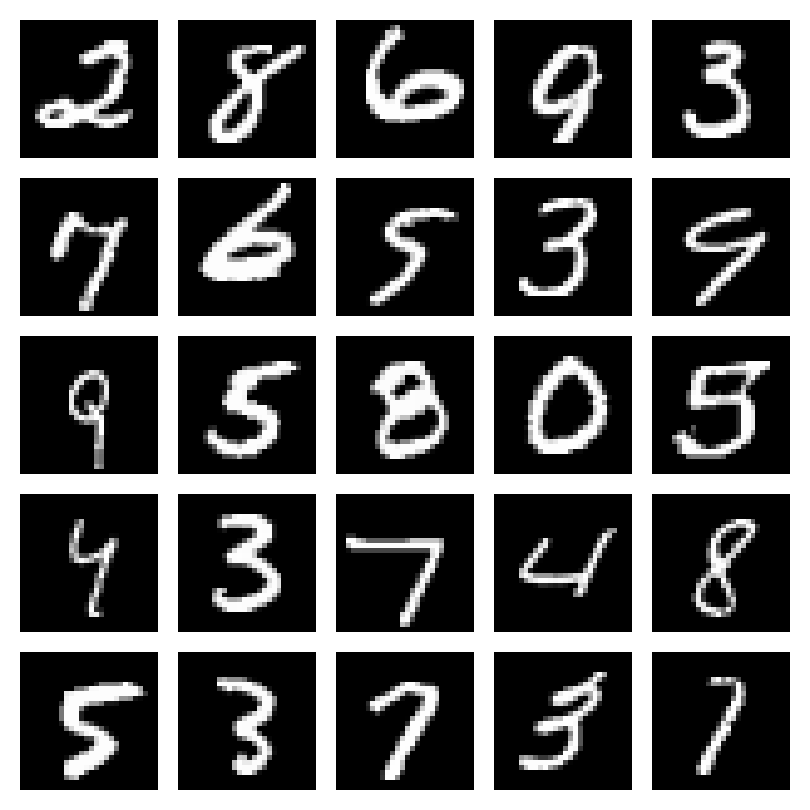

In [28]:
dataiter = iter(trainloaded)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)] 
fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)
for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [32]:
itercount = len(trainloaded)/64

In [33]:
def train(autoencoder, data, epochs=100):
    optim = torch.optim.Adam(autoencoder.parameters())
    for i in range(epochs):
        netloss = 0
        print("Epoch " + str(i + 1) +":", end = ' ')
        for x, y in data:
            x = x.to(device)
            optim.zero_grad()
            xhat = autoencoder(x)
            loss = ((x - xhat)**2).sum() + autoencoder.encoder.kl
            netloss += loss.item()
            loss.backward()
            optim.step()
        netloss = netloss/itercount
        print("Overall Loss:", netloss)
    return autoencoder

In [34]:
autoencoder = VAE(inputdim, hiddendim, latentdim).to(device)

In [35]:
autoencoder = train(autoencoder, trainloaded)

Epoch 1: Overall Loss: 195225.9301988204
Epoch 2: Overall Loss: 175230.14349671802
Epoch 3: Overall Loss: 171862.33959998097
Epoch 4: Overall Loss: 169320.1533663908
Epoch 5: Overall Loss: 167335.4701412671
Epoch 6: Overall Loss: 165700.54159531964
Epoch 7: Overall Loss: 164381.92394406392
Epoch 8: Overall Loss: 163270.18553201103
Epoch 9: Overall Loss: 162330.75722983258
Epoch 10: Overall Loss: 161423.00084427322
Epoch 11: Overall Loss: 160827.86020143644
Epoch 12: Overall Loss: 160112.2689366914
Epoch 13: Overall Loss: 159548.23994601407
Epoch 14: Overall Loss: 159111.86342988964
Epoch 15: Overall Loss: 158781.00304414003
Epoch 16: Overall Loss: 158182.1255113204
Epoch 17: Overall Loss: 157798.35473744292
Epoch 18: Overall Loss: 157410.64921637176
Epoch 19: Overall Loss: 157183.2094570491
Epoch 20: Overall Loss: 156907.87510107495
Epoch 21: Overall Loss: 156533.47106283295
Epoch 22: Overall Loss: 156262.48561762748
Epoch 23: Overall Loss: 155949.686221699
Epoch 24: Overall Loss: 1557

In [36]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

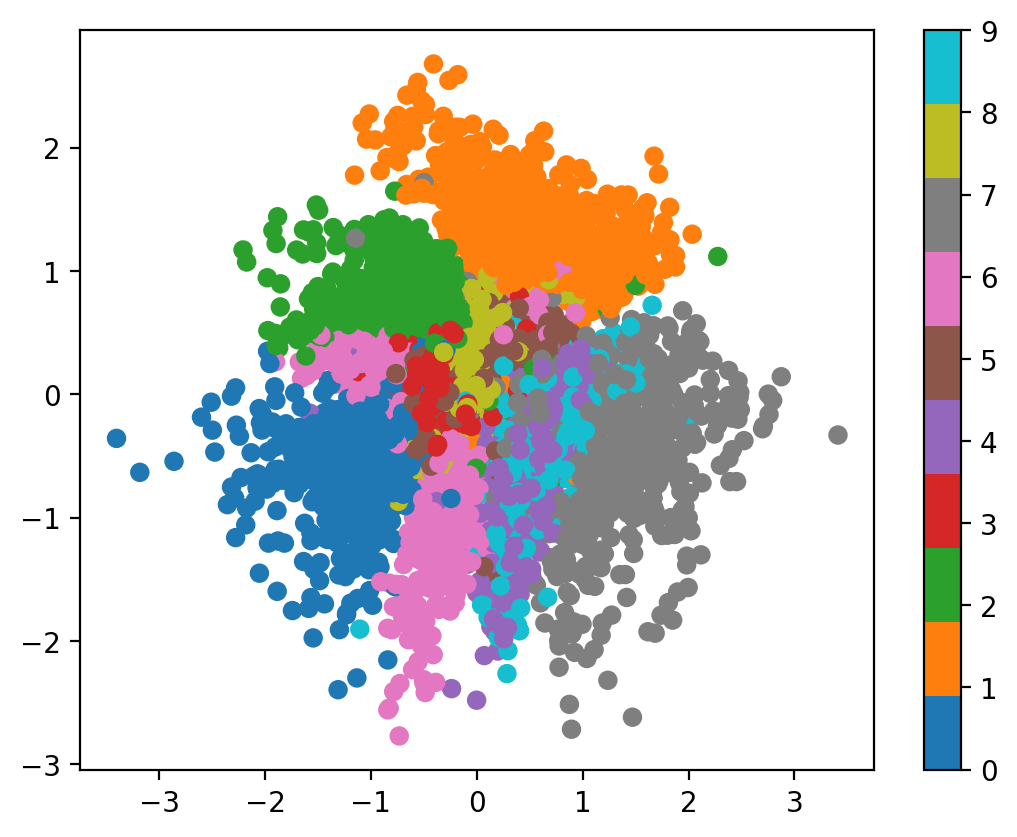

In [41]:
plot_latent(autoencoder, trainloaded)

In [38]:
def reconstructdigits(autoencoder, r0=(-5, 10), r1=(-10, 5), n=15):
    w=28
    image = np.zeros((n*w, n*w))
    for i, x2 in enumerate(np.linspace(*r1, n)):
        for j, x1 in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x1, x2]]).to(device)
            xhat = autoencoder.decoder(z)
            xhat = xhat.reshape(28, 28)
            xhat = xhat.to('cpu')
            xhat = xhat.detach().numpy()
            image[(n-i-1)*w:(n-i)*w, j*w:(j+1)*w] = xhat
    plt.imshow(image, extent=[*r0, *r1])

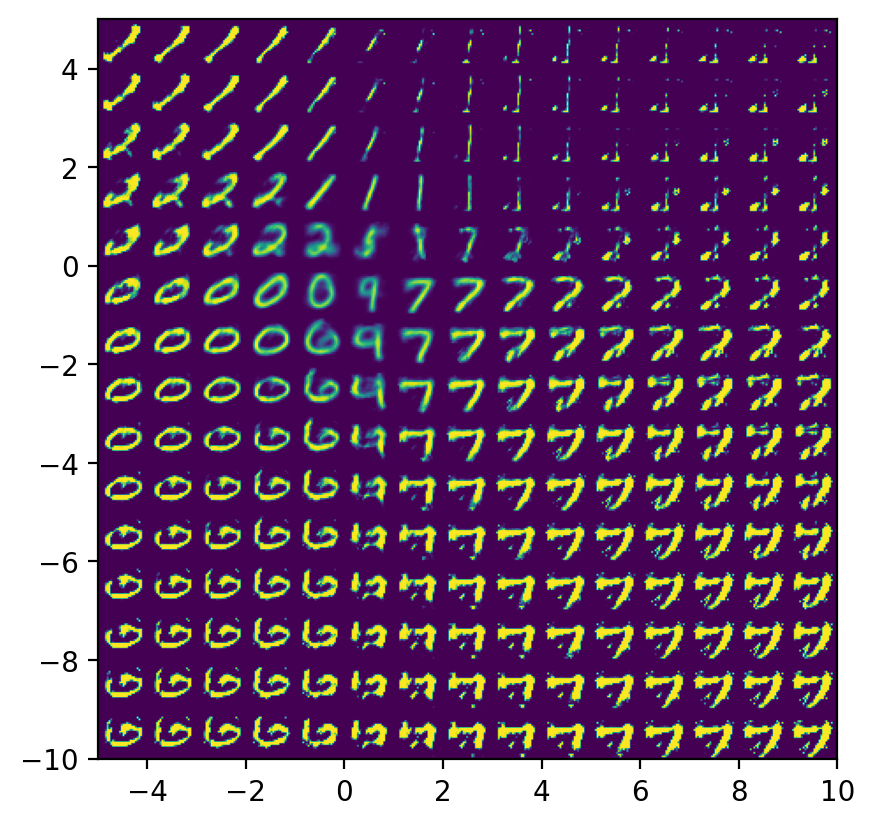

In [42]:
reconstructdigits(autoencoder)